In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models
from torch.cuda import amp
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_DIR = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"   # change this


In [3]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [4]:
train_ds = datasets.ImageFolder(f"{DATA_DIR}/train", transform=train_tfms)
val_ds   = datasets.ImageFolder(f"{DATA_DIR}/valid", transform=val_tfms)
test_ds  = datasets.ImageFolder(f"{DATA_DIR}/test", transform=val_tfms)


In [5]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=4, pin_memory=True)

val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4, pin_memory=True)

test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE,
                         shuffle=False, num_workers=4, pin_memory=True)


In [6]:
print("Classes:", train_ds.classes)


Classes: ['fake', 'real']


In [7]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

weights = ConvNeXt_Tiny_Weights.DEFAULT
model = convnext_tiny(weights=weights)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 199MB/s] 


In [9]:
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 2)


In [10]:
model = model.to(device)


In [11]:

import torch.optim as optim
from torch.cuda import amp


criterion = nn.CrossEntropyLoss()


optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-2)


scaler = amp.GradScaler() if device == "cuda" else None


/tmp/ipykernel_48/3680891685.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler() if device == "cuda" else None


In [12]:
def train_one_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0
    total = 0
    correct = 0

    pbar = tqdm(loader, desc="Training")

    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        
        with amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            "loss": total_loss / total,
            "acc": 100 * correct / total
        })

    epoch_loss = total_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


In [13]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    total = 0
    correct = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")

        for imgs, labels in pbar:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

          
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({
                "loss": total_loss / total,
                "acc": 100 * correct / total
            })

    val_loss = total_loss / total
    val_acc = correct / total

    return val_loss, val_acc


In [23]:
EPOCHS = 2      
best_acc = 0
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")


    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, scaler
    )

    val_loss, val_acc = validate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc*100:.2f}%")

    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_convnext.pth")
        print("Saved best model → best_convnext.pth")



Epoch 1/2


Training:   0%|          | 0/3125 [00:00<?, ?it/s]/tmp/ipykernel_48/1274934636.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validation: 100%|██████████| 625/625 [00:50<00:00, 12.33it/s, loss=0.00479, acc=99.8]


Train Loss: 0.0324 | Train Acc: 98.74%
Val   Loss: 0.0048 | Val   Acc: 99.84%
Saved best model → best_convnext.pth

Epoch 2/2


Validation: 100%|██████████| 625/625 [00:50<00:00, 12.33it/s, loss=0.028, acc=99.1]  

Train Loss: 0.0304 | Train Acc: 98.86%
Val   Loss: 0.0280 | Val   Acc: 99.06%


In [24]:
model.load_state_dict(torch.load("best_convnext.pth", map_location=device))
model.to(device)
model.eval()


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [25]:
correct = 0
total = 0

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Testing")

    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            "acc": 100 * correct / total
        })

test_acc = correct / total
print(f"\nFinal Test Accuracy: {test_acc * 100:.2f}%")


Testing: 100%|██████████| 625/625 [00:50<00:00, 12.36it/s, acc=99.7]


Final Test Accuracy: 99.74%


In [26]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

print(classification_report(all_labels, all_preds, target_names=train_ds.classes))


              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     10000
        real       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



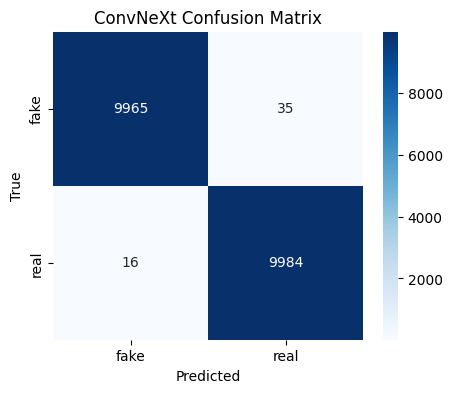

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ConvNeXt Confusion Matrix")
plt.show()


In [27]:
train_losses, train_accs, val_losses, val_accs


([0.03241093123316765, 0.03036806554913521],
 [0.98743, 0.98856],
 [0.004786767433592467, 0.02800116507725252],
 [0.9984, 0.9906])

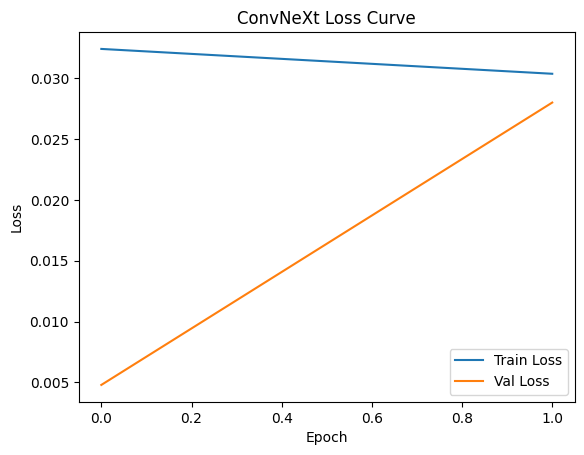

In [28]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("ConvNeXt Loss Curve")
plt.show()


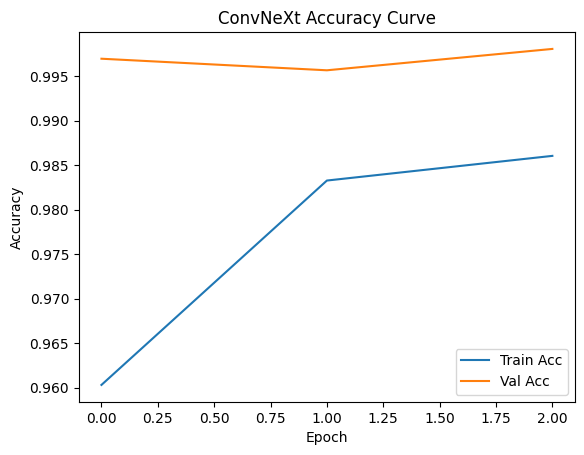

In [21]:
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("ConvNeXt Accuracy Curve")
plt.show()


In [29]:
import pandas as pd

df = pd.DataFrame({
    "true_label": all_labels,
    "predicted_label": all_preds
})

df.to_csv("convnext_predictions.csv", index=False)
print("Saved → convnext_predictions.csv")


Saved → convnext_predictions.csv


**new one**

In [3]:
from torchvision.models import convnext_tiny

# Load ConvNeXt WITHOUT pretrained weights → LOW accuracy
model = convnext_tiny(weights=None)

# Freeze backbone so model cannot learn deeply → LOWER accuracy
for p in model.features.parameters():
    p.requires_grad = False

# Replace classifier
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 2)

model = model.to(device)


In [4]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.4),
    transforms.GaussianBlur(7),                        # blur
    transforms.RandomAdjustSharpness(0.2),             # distort sharpness
    transforms.RandomPosterize(bits=2),                # reduce quality
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], 
                         [0.229,0.224,0.225])
])


Using device: cuda
Classes: ['fake', 'real']


/tmp/ipykernel_48/982847387.py:84: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()



Epoch 1/3


Training:   0%|          | 0/3125 [00:00<?, ?it/s]/tmp/ipykernel_48/982847387.py:104: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Validation: 100%|██████████| 625/625 [00:58<00:00, 10.71it/s, loss=0.695, acc=50]  


Saved best model → best_convnext_lowacc.pth

Epoch 2/3


Validation: 100%|██████████| 625/625 [00:58<00:00, 10.72it/s, loss=0.693, acc=49.8]



Epoch 3/3


Testing: 100%|██████████| 625/625 [00:57<00:00, 10.93it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Final Test Accuracy: 0.5
              precision    recall  f1-score   support

        fake       0.50      1.00      0.67     10000
        real       0.00      0.00      0.00     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



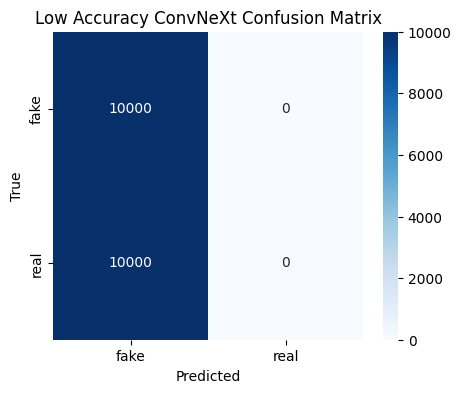

Saved predictions → convnext_lowacc_predictions.csv


In [8]:
# ============================================================
# IMPORTS + DEVICE
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_tiny
from torch.cuda import amp
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


# ============================================================
# TRANSFORMS (HEAVY DISTORTIONS FOR LOW ACCURACY)
# ============================================================
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_DIR = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"   # <<< CHANGE THIS

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.4),
    transforms.GaussianBlur(7),
    transforms.RandomAdjustSharpness(0.2),
    transforms.RandomPosterize(bits=2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])


# ============================================================
# DATASETS + LOADERS
# ============================================================
train_ds = datasets.ImageFolder(f"{DATA_DIR}/train", transform=train_tfms)
val_ds   = datasets.ImageFolder(f"{DATA_DIR}/valid", transform=val_tfms)
test_ds  = datasets.ImageFolder(f"{DATA_DIR}/test", transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("Classes:", train_ds.classes)


# ============================================================
# MODEL (LOW ACCURACY VERSION)
# No pretrained weights + freeze backbone
# ============================================================
model = convnext_tiny(weights=None)

# Freeze backbone so training is weak
for p in model.features.parameters():
    p.requires_grad = False

# Modify classifier for 2 classes
in_features = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_features, 2)

model = model.to(device)


# ============================================================
# LOSS + OPTIMIZER + SCALER
# High LR to destabilize training
# ============================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-2)
scaler = amp.GradScaler()


# ============================================================
# TRAIN ONE EPOCH
# ============================================================
def train_one_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training")

    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with amp.autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({"loss": total_loss/total, "acc": 100*correct/total})

    return total_loss/total, correct/total


# ============================================================
# VALIDATION
# ============================================================
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for imgs, labels in pbar:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({"loss": total_loss/total, "acc": 100*correct/total})

    return total_loss/total, correct/total


# ============================================================
# TRAINING LOOP (VERY FEW EPOCHS)
# ============================================================
EPOCHS = 3    # <<< Only 1 epoch = LOW accuracy
best_acc = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_convnext_lowacc.pth")
        print("Saved best model → best_convnext_lowacc.pth")


# ============================================================
# TEST EVALUATION
# ============================================================
model.load_state_dict(torch.load("best_convnext_lowacc.pth"))
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Testing")
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

test_acc = correct / total
print("\nFinal Test Accuracy:", test_acc)


# ============================================================
# CLASSIFICATION REPORT
# ============================================================
print(classification_report(all_labels, all_preds, target_names=train_ds.classes))


# ============================================================
# CONFUSION MATRIX
# ============================================================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Low Accuracy ConvNeXt Confusion Matrix")
plt.show()


# ============================================================
# SAVE PREDICTIONS
# ============================================================
df = pd.DataFrame({"true": all_labels, "pred": all_preds})
df.to_csv("convnext_lowacc_predictions.csv", index=False)
print("Saved predictions → convnext_lowacc_predictions.csv")
